# Visualising the results of extracting the internal models

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.utils import cut_end_points

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [3]:
RESULTS_PATH = "./posteriors/internal_model/posterior_with_multiple_messages/"
DATASETS = [
    d 
    for d in os.listdir(RESULTS_PATH) 
    if os.path.isdir(os.path.join(RESULTS_PATH, d))
]

SPLIT_NUMBER = 0

In [4]:
results_dict = {dataset: {} for dataset in DATASETS}

for dataset in DATASETS:
    with open(
        os.path.join(RESULTS_PATH, dataset, "mle_loss.json"), "r"
    ) as f:
        results_dict[dataset]["mle_loss"] =  json.load(f)

    with open(
        os.path.join(RESULTS_PATH, dataset, "posterior_parameter_samples.json"), "r"
    ) as f:
        results_dict[dataset]["posterior_parameter_samples"] =  json.load(f)


In [5]:
posterior_parameter_samples = []

for a in results_dict[dataset]["posterior_parameter_samples"]:
    posterior_parameter_samples_repeat = []
    for b in a:
        for c in b:
            if c is not None:
                posterior_parameter_samples_repeat.append(c)
    
    posterior_parameter_samples.append(np.array(posterior_parameter_samples_repeat))

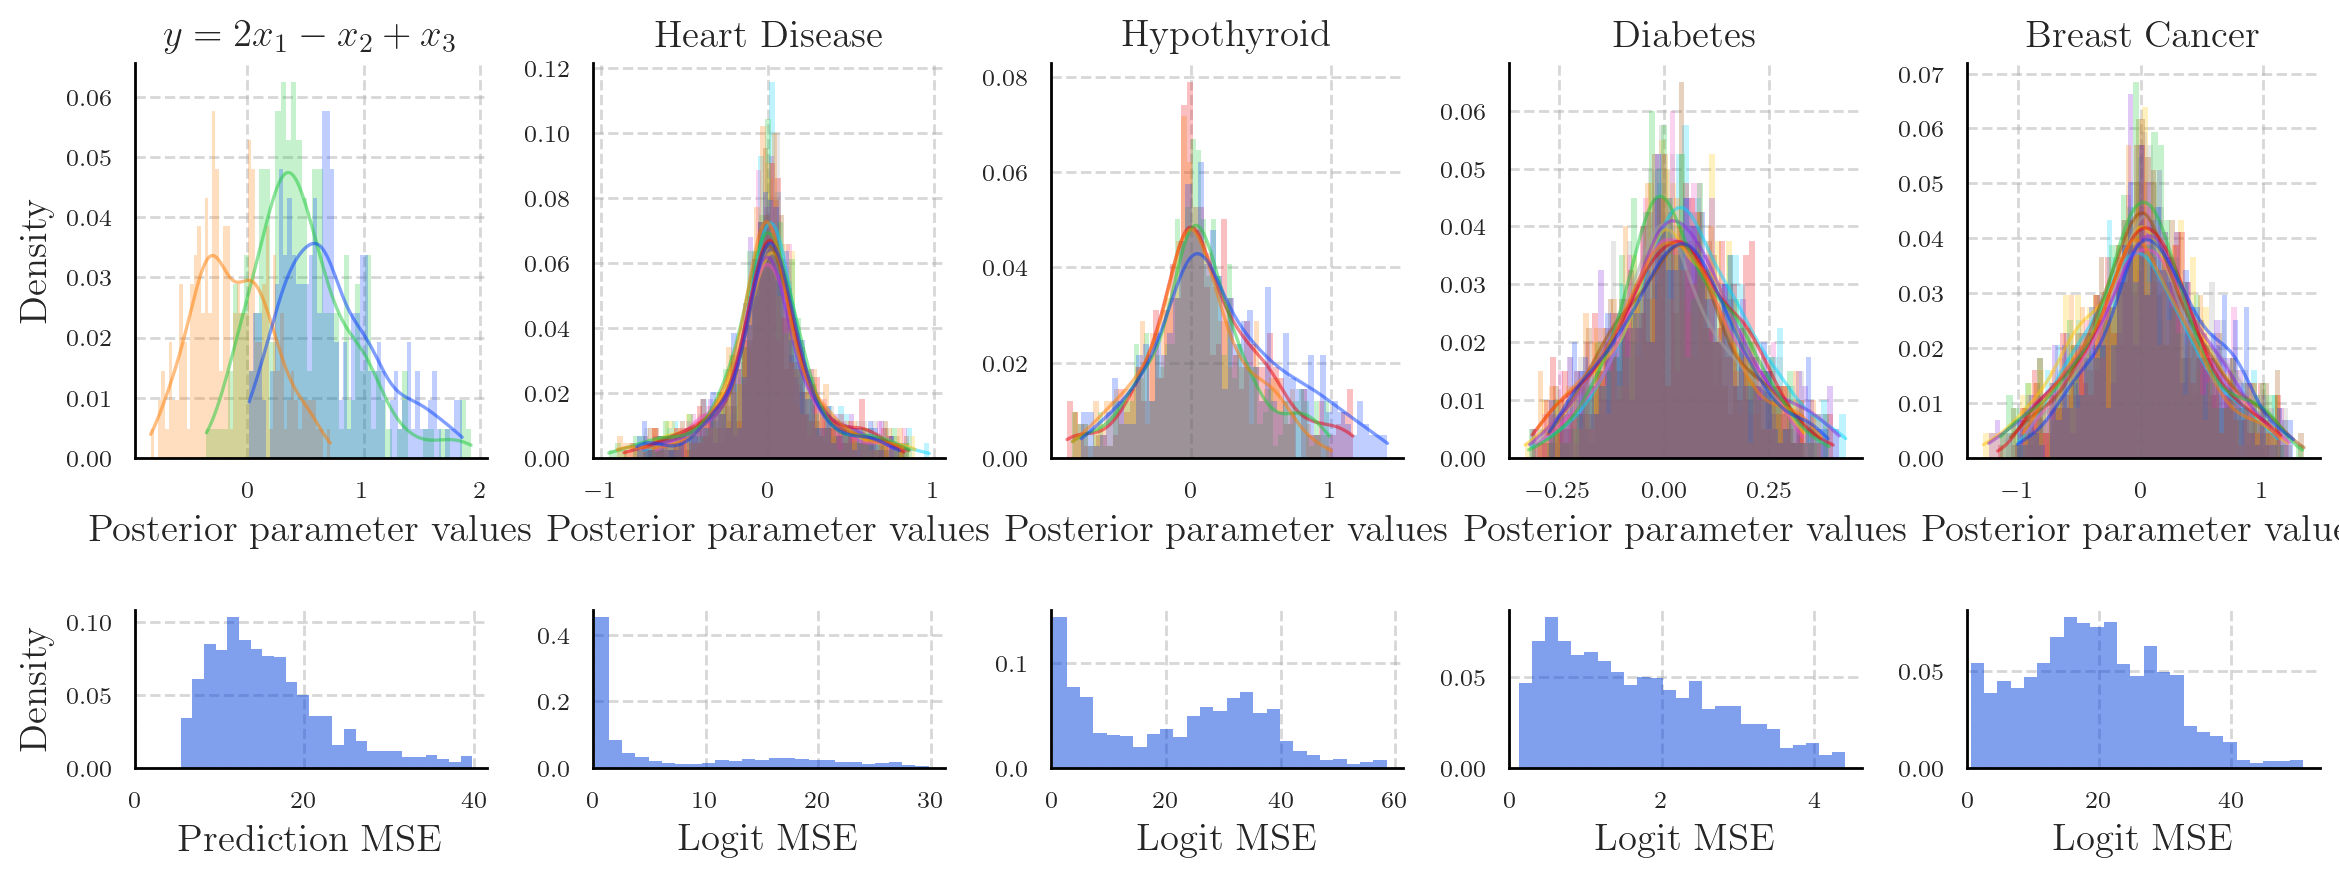

In [6]:
plt.close()


fontsize = 14

dataset_order = [
    "fake_data",
    "heart_disease",
    "hypothyroid",
    "diabetes",
    "breast_cancer",
    # "california_housing",
    # "wine_quality",
]

dataset_nice_names = {
    "fake_data": r"$y = 2 x_1 - x_2 + x_3$",
    "uti": "UTI",
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "heart_disease": "Heart Disease",
    "wine_quality": "Wine Quality",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

mle_hist_config = dict(
    alpha=0.5,
    edgecolor="black",
    linewidth=0.0,
    bins=25,
    kde=False,
    common_norm=False, 
    common_bins=False,
    stat="probability",
)

priors_hist_config = dict(
    alpha=0.25,
    palette="bright",
    linewidth=0.0,
    bins=50,
    kde=True,
    common_norm=False, 
    common_bins=False,
    stat="probability",
    line_kws=dict(
        alpha=.5,

    ),
)


n_rows = 2
n_cols = len(dataset_order)

with graph_theme():
    fig, axes = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(2*linewidth*(5/6), 0.5*2*linewidth/1.618),
        height_ratios=[1, 0.4]
    )

    col = 0
    for dataset in dataset_order:

        # loading the data
        mle_loss = np.array([
            a 
            for a_list_list in results_dict[dataset]["mle_loss"]
            for a_list in a_list_list
            for a in a_list
            if a is not None
        ])

        posterior_parameter_samples = []
        for a in results_dict[dataset]["posterior_parameter_samples"]:
            posterior_parameter_samples_repeat = []
            for b in a:
                for c in b:
                    if c is not None:
                        posterior_parameter_samples_repeat.append(c)
            
            posterior_parameter_samples.append(
                np.array(posterior_parameter_samples_repeat)
            )

        posterior_parameter_samples = np.array(
            posterior_parameter_samples[SPLIT_NUMBER]
        )[:, 1:] # not intercept term

        # plotting the prior parameters
        ax = axes[0, col]
        sns.histplot(
            [
                cut_end_points(f, 2.5, 97.5) 
                for f in posterior_parameter_samples.T
            ],
            ax=ax,
            legend=False,
            **priors_hist_config
        )

        ax.set_title(dataset_nice_names[dataset], fontsize=fontsize)
        ax.set_xlabel("Posterior parameter values", fontsize=fontsize)

        if col > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Density", fontsize=fontsize)


        # plotting the mle loss
        ax = axes[1, col]
        sns.histplot(
            cut_end_points((mle_loss), 2.5, 97.5),
            ax=ax,
            color="xkcd:blue",
            **mle_hist_config
        )

        ax.set_xlim(0)

        if dataset not in ["california_housing", "fake_data"]:
            ax.set_xlabel("Logit MSE", fontsize=fontsize)
        else:
            ax.set_xlabel(
                "Prediction MSE", fontsize=fontsize
            )

        if col > 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Density", fontsize=fontsize)



        col += 1

    fig.subplots_adjust(
        hspace=0.55, wspace=0.3,
        left=0.055, right=0.975,
        top=0.925, bottom=0.125
    )

    fig.savefig(
        "results/posterior_extraction_grid.pdf", 
    )

    fig.savefig(
        "results/posterior_extraction_grid.svg", 
    )

    fig.savefig(
        "results/posterior_extraction_grid.png", 
        dpi=300
    )



    plt.show()